## `Oligopool Calculator` in Action!

**Author** Ayaan Hossain

**Updated** September 30, 2024

This `jupyter` notebook will demonstrate the usage of `Oligopool Calculator` and describe its many functions.

### Table of Contents

* [Notebook Setup](#Notebook-Setup)
* [What is Oligopool Calculator?](#What-is-Oligopool-Calculator?)
* [Design Mode Walthrough - An oligopool of 6K ribozyme variants](#Design-Mode-Walkthrough---An-oligopool-of-6K-ribozyme-variants)
    * [Simulating the problem](#Simulating-the-problem)
    * [Reviewing constraints and formulating gameplan](#Reviewing-constraints-and-formulating-gameplan)
    * [Primer design review](#Primer-design-review)
    * [Storing the plasmid background](#Storing-the-plasmid-background)
    * [Designing the tri-compatible primers](#Designing-the-tri-compatible-primers)
    * [Designing orthogonal barcodes](#Designing-orthogonal-barcodes)
    * [Adding neutral motifs, spacers and finalizing library](#Adding-neutral-motifs,-spacers-and-finalizing-library)
    * [Splitting and padding oligos](#Splitting-and-padding-oligos)

### Notebook Setup

We will need to have `Oligopool Calculator` installed to proceed. You can install it by uncommenting and executing the following cell.

In [1]:
# !pip install oligopool

Let's import `oligopool`.

In [2]:
import oligopool as op

We will need `numpy` to do some math, and we will use `pandas` as our data container.

In [3]:
import numpy  as np
import pandas as pd

We will also need `matplotlib`/`seaborn` for plotting.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

We're all set.

### What is Oligopool Calculator?

Oligonucleotide pools (oligopools) have revolutionized synthetic biology by enabling large-scale, cost-effective synthesis of hundreds of thousands of unique, short single-stranded DNA sequences.

These oligopools facilitate the creation and study of various biological components, including de novo promoters, ribozymes, protein scaffolds, and CRISPR libraries. Massively parallel reporter assays (MPRAs) are utilized to clone and assess the functionality of these variants using high-throughput next-generation sequencing (NGS), which can generate billions of short reads per experiment.

Looking ahead, advancements are expected in the number and length of oligos, NGS throughput, and reductions in manufacturing costs.

![Oligopool Calculator Workflow](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/workflow.svg)

`Oligopool Calculator` is a comprehensive tool for designing and analyzing large-scale oligonucleotide pools.

In **(a)** `Design Mode`, the algorithms optimize various elements of the oligopool, including barcodes, primers, spacers, and degenerate motifs. It ensures that these components are maximally distinct, non-repetitive, and free from undesired sequences or structures. The tool also enables the splitting of long oligos into shorter fragments with optimized overlaps for downstream assembly.

The **(b)** `Analysis Mode` of `Oligopool Calculator` facilitates the processing of next-generation sequencing (NGS) data derived from barcoded amplicons. This mode allows for efficient mapping of variants and their associated barcodes, producing count matrices for quantitative assessment of variant functionality. Two types of counting operations are supported: Association counting for assessing synthesis accuracy, and Combinatorial counting for analyzing multiple barcode combinations from sequencing reads.

Overall `Oligopool Calculator` provides synthetic biologists with a unified platform for oligopool design and characterization, addressing the need for a standardized approach across different projects and labs. This tool eliminates the need for reinventing design scripts or using suboptimal strategies, making it particularly valuable for designing and analyzing pools containing millions of defined variants.

### Design Mode Walkthrough - An oligopool of 6K ribozyme variants

Suppose we want to design and test a library of 6,232 ribozyme variants based on the following architecture.

![Ribozyme Library Architecture](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/architecture.svg)

To characterize the activity of our library in _E. coli_ we want to adopt a two-barcode strategy for designing the oligopool. Because ribozymes are self-cleaving, the two barcodes, BC1 and BC2, placed before and after the core variant would be separated after catalysis. This would allow us to count the ratio of their separation to quantify the efficiency of the ribozymes on a proportional scale (i.e., 0 to 100% cleavage efficiency) and normalize against wildtype ribozyme cleavage efficiencies.

#### Simulating the problem

For the purposes of demonstration, let us first generate a random library of 59-73 mers (designing exact ribozymes is beyond the scope here) and assume that the library will be cloned into a 5 kb plasmid backbone for characterization, which we will also generate randomly.

In [5]:
rng = np.random.default_rng(seed=42)

In [6]:
dna = ['A', 'T', 'G', 'C']

In [7]:
ribozymes = []
while len(ribozymes) < 6232:
    variant = ''.join(rng.choice(dna, size=rng.integers(low=59, high=74)))
    if 'GAATTC' in variant or 'GACGTC' in variant:
        # Skipping if random variant has EcoRI or AatII motif
        continue
    ribozymes.append(variant)

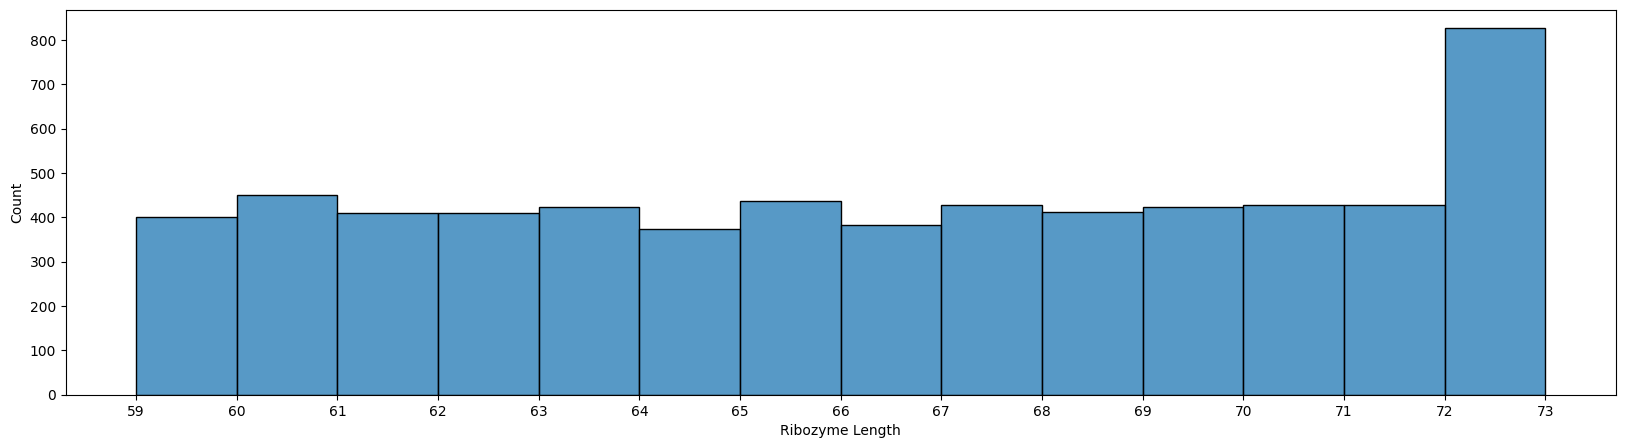

In [8]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
sns.histplot([len(x) for x in ribozymes], binwidth=1)
ax.set_xticks(np.arange(59,74))
ax.set_xlabel('Ribozyme Length')
plt.show()

In [9]:
len(ribozymes)

6232

In [10]:
plasmid = ''.join(rng.choice(dna) for _ in range(5000))

In [11]:
len(plasmid) # 5 kbp long plasmid

5000

#### Reviewing constraints and formulating gameplan

We have generated 6,232 simulated candidates between 59 to 73 bp in length, and a plasmid of length 5 kbp. We want to use `EcoRI` and `AatII` as our restriction sites as part of the characterization process.

We can now use `Oligopool Calculator` to design the following.
* Three primers, each 20bp in length,
* The prefix and suffix barcodes each 11bp in length, and
* Variable length spacers ranging from 3 to 17bp to pad the oligos to 170bp.

As constraints, we aim to have the following.
* The primers should not have off-target binding within the library or to the backbone,
* Addition of primers, barcodes or spacers should not contain `EcoRI` and `AatII` motifs or introduce them at the edges, and
* The barcodes should all have at least 3 mismatches separating each other.

Other realistic constraints, such as exclusion of all palindomic hexamers, or polymeric runs such as `'AAAAA'`, ..., `'CCCC'` may be included as they were in the original projects, but we will skip those for this demonstration. In reality, constaints will depend on the design project.

How do we begin? By asking `help` from `Oligopool Calculator`.

In [12]:
help(op)

Help on package oligopool:

NAME
    oligopool

DESCRIPTION
    oligopool v2024.10.05
    by ah

    Automated design and analysis of oligopool libraries.

    The various modules in Oligopool Calculator can be used
    interactively in a jupyter notebook, or be used to define
    scripts for design and analysis pipelines on the cloud.

    Oligopool Calculator offers two modes of operation
        -   Design Mode for designing oligopool libraries, and
        - Analysis Mode for analyzing oligopool datasets.

    Design Mode workflow

        1. Initialize a pandas DataFrame with core library elements.
            a. The DataFrame must contain a unique 'ID' column serving as primary key.
            b. All other columns in the DataFrame must be DNA sequences.
        2. Define any optional background sequences via the background module.
        3. Add necessary oligopool elements with constraints via element modules.
        4. Optionally, split long oligos and pad them via assembly m

Per the help, will need to use the `barcode`, `primer`, and `spacer` modules to add the library elements.

#### Primer design review

Generally, primers are the most constrained elements in an oligopool library because they have to follow a desired sequence constraint (such as `5'-GC` clamps), be free of inhibitory secondary structures, be very specific to the library and have minimal off-targeting to background. We recommended designing primers first.

![Primer Design](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/primer.svg)

At any step in the design process if we get stuck, `Oligopool Calculator` will tell us what is preventing it from succeeding and we can relax or modify our constraints accordingly.

How do we design primers?

In [13]:
help(op.primer)

Help on function primer in module oligopool.primer:

primer(input_data: str | pandas.core.frame.DataFrame, oligo_length_limit: int, primer_sequence_constraint: str, primer_type: int, minimum_melting_temperature: float, maximum_melting_temperature: float, maximum_repeat_length: int, primer_column: str, output_file: str | None = None, paired_primer_column: str | None = None, left_context_column: str | None = None, right_context_column: str | None = None, excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None, background_directory: str | None = None, verbose: bool = True) -> Tuple[pandas.core.frame.DataFrame, dict]
    Designs constrained primers with specified melting temperature and non-repetitiveness
    for all variants in the oligopool. Ensures compatibility with paired primers and minimizes
    dimer formation. Returns a DataFrame of designed primers, optionally saving to `output_file`
    in CSV format.

    Required Parameters:
        - `input_data` (`str` / `pd.

Two things should stand out here.

First, primer design involves consideration of background sequences to minimize off-target amplification, such as from the plasmid we set up. We will need to compute this information prior to primer design.

Second, primer design involves consideration of pairing information. If we only had two primers (one forward and one reverse) the order of their design would not matter. But in our problem, there are two forward primers (pink and orange) both of which are coupled to a single reverse primer (yellow). It will be important to design them in the right order, as we will discuss shortly.

Let us first solve the background problem.

#### Storing the plasmid background

`Oligopool Calculator` makes it easy to define a background for primer design via the `background` module.

In [14]:
help(op.background)

Help on function background in module oligopool.background:

background(input_data: list | str | pandas.core.frame.DataFrame, maximum_repeat_length: int, output_directory: str, verbose=True) -> dict
    The background function creates a k-mer database from a list or CSV file of background sequences.
    This database is used during primer design to ensure primers are non-repetitive to the background,
    minimizing off-target amplification. Non-repetitiveness is regulated by the maximum shared repeat
    length parameter. The generated database is saved in the specified `output_directory`.

    Required Parameters:
        - `input_data` (`list` / `str` / `pd.DataFrame`): background for primers; can be a CSV file or a DataFrame.
        - `maximum_repeat_length` (`int`): Max repeat length between primers and background (between 6 and 20).
        - `output_directory` (`str`): Directory to store the generated background k-mer database.
        - `verbose` (`bool`): If `True`, logs updat

> **Note:** If you want to modify the background post-hoc, or want to define your background using a custom strategy, directly use the `vectorDB` module, which behaves like a dictionary. For details use `help(op.vectorDB)`. The `background` module just wraps around it and offers an one-time use simple interface to `vectorDB`.

In [15]:
background_directory = 'demo.oligopool.background' # Path to store our background

Let's remove the background if one exists already, for this demonstration.

In [16]:
!rm -rf $background_directory

Execute the `background` module.

In [17]:
background_stats = op.background(
    input_data=plasmid,
    maximum_repeat_length=8,
    output_directory=background_directory)


[Oligopool Calculator: Design Mode - Background]
                                                  
 Required Arguments
 Background      Data: 1 Unique Sequence(s)
    Maximum    Repeat: Up to 8 Base Pair(s) Background Repeats
     Output Directory: demo.oligopool.background               
                                                 
[Computing Background]
 Sequence 1: TAGCTCAGACGTCGCCTCGA... Inserted
 Time Elapsed: 0.02 sec                       
                        
[Background Statistics]
 Background Status: Successful
      k-mer  Space: 131,072 Unique 9-mers
       Fill  Count:   4,888 Unique 9-mers (  3.73 %)
       Left  Count: 126,184 Unique 9-mers ( 96.27 %) 
 Time Elapsed: 0.03 sec                              



In [18]:
background_stats

{'status': True,
 'basis': 'solved',
 'step': 1,
 'step_name': 'computing-background',
 'vars': {'kmer_space': 131072, 'fill_count': 4888, 'left_count': 126184},
 'warns': {}}

We've now stored the background, and are ready to design the three primers.

> **Note**: All `Oligopool Calculator` functions should return a pipeline statistics dictionary recapitulating the output from the last step performed in the function. If the operation completed successfully, the `status` key will be marked as `True` and `basis` will be marked as `'solved'`.

#### Designing the tri-compatible primers

All `Design Mode` input and output is mediated through a `pandas` `DataFrame` to facilitate carefully piplined designs. Let us store the variant candidates in a dataframe and start the design process.

In [19]:
df = pd.DataFrame({
    'ID': [f'ribozyme_{x+1:04d}' for x in range(len(ribozymes))],
    'EcoRI': 'GAATTC',
    'Variant':ribozymes,
    'AatII': 'GACGTC',
})

In [20]:
df.tail(5)

,ID,EcoRI,Variant,AatII
6227,ribozyme_6228,GAATTC,GTTTCTTCTTGCAGTGGTCGGGTGAAGGTCGTTGACGGTCTTCACA...,GACGTC
6228,ribozyme_6229,GAATTC,CGAATGCTCAAACCCCGACAGGTTGCTTAGCGTGTTGACAGGTTTT...,GACGTC
6229,ribozyme_6230,GAATTC,CGGCCTAATGCCACGCAGCTTGTCATCTCTGTTAGCGACCATAATT...,GACGTC
6230,ribozyme_6231,GAATTC,TATGTCGAAGACGAATGTGAAAACACAATAACGGTATCGTATGCGA...,GACGTC
6231,ribozyme_6232,GAATTC,GTGTGGAAGAAATAATGAGAGTAGGCAAGTAGGATCACCTTTTGGC...,GACGTC


Given that the primers are coupled, an optimal solution here is to design the innermost (pink) forward primer first, and then design the reverse primer (yellow), followed by designing the outermost (orange) forward primer. This allows all three primers to be compatible with each other.

An alternate solution would involve designing the (yellow) reverse primer first, and then designing the two forward primers successively.

However, if we designed the (yellow) reverse primer at the end, it would be difficult to ensure that it is compatible with both forward primers simultaneously.

In [21]:
# help(op.primer)

In [22]:
df, stats = op.primer(
    input_data=df,
    oligo_length_limit=170,                    # Must not exceed 170bp at any stage
    primer_sequence_constraint='N'*18 + 'WW',  # The last two bases must be weak
    primer_type=0,                             # This is a forward primer
    primer_column='PinkForwardPrimer',         # Store designs in 'PinkForwardPrimer' column
    left_context_column='Variant',             # Next to 'Variant' column
    right_context_column='AatII',              # Before 'AatII' column
    paired_primer_column=None,                 # No paired primer yet
    excluded_motifs=['GAATTC', 'GACGTC'],      # Ensure EcoRI and AatII do not emerge as motifs
    minimum_melting_temperature=53,            # Tm = 53°C at least
    maximum_melting_temperature=55,            # Tm = 55°C at most
    maximum_repeat_length=8,                   # No more than 8-mer repeats allowed
    background_directory=background_directory, # As setup before
    output_file=None)                          # In-memory return, no CSV written here


[Oligopool Calculator: Design Mode - Primer]
                                              
 Required Arguments
      Input Data       : DataFrame w/ 6,232 Record(s)
      Oligo Limit      : At most 170 Base Pair(s)     
     Primer Sequence   : A 20 Base Pair IUPAC Constraint
     Primer Type       : Forward Primer Design           
    Melting Temperature: 53 to 55 °C           
     Repeat Length     : Up to 8 Base Pair(s) Oligopool Repeats
     Primer Column     : Output in Column 'PinkForwardPrimer'   
     Output File       : In-Memory DataFrame                  
                                             
 Optional Arguments
     Paired Primer     : None Specified
       Left Context    : Input from Column 'Variant'
      Right Context    : Input from Column 'AatII'   
   Excluded Motifs     : 2 Unique Motif(s)         
 Background Database   : Contains 4,888 Unique 9-mers
                                                      
[Step 1: Parsing Oligo Limit]
 Maximum Oligo Leng

The designed primer is predicted to be free from hairpin structures with low homodimer probability.

Let us now design the two remaining primers in silent mode.

In [23]:
df, _ = op.primer(
    input_data=df,                               # Updated DataFrame along pipeline chain
    oligo_length_limit=170,
    primer_sequence_constraint='WW' + 'N'*18,    # Last two bases must be weak in reverse complement
    primer_type=1,                               # This is a reverse primer
    primer_column='YellowReversePrimer',         # Store designs in 'YellowReversePrimer' column
    left_context_column='PinkForwardPrimer',     # Next to 'PinkForwardPrimer' column
    right_context_column='AatII',                # Before 'AatII' column
    paired_primer_column='PinkForwardPrimer',    # Yellow reverse primer paired with pink forward primer
    minimum_melting_temperature=53,
    maximum_melting_temperature=55,
    maximum_repeat_length=8,
    excluded_motifs=['GAATTC', 'GACGTC'],
    background_directory=background_directory,
    verbose=False)                               # Silent Mode

In [24]:
df, _ = op.primer(
    input_data=df,                                # Updated DataFrame along pipeline chain
    oligo_length_limit=170,
    primer_sequence_constraint='N'*18 + 'WW',     # The last two bases must be weak
    primer_type=0,                                # This is a forward primer
    primer_column='OrangeForwardPrimer',          # Store designs in 'OrangeForwardPrimer' column
    left_context_column='EcoRI',                  # Next to 'EcoRI' column
    right_context_column='Variant',               # Before 'Variant' column
    paired_primer_column='YellowReversePrimer',   # Orange forward primer paired with yellow reverse primer
    minimum_melting_temperature=53,
    maximum_melting_temperature=55,
    maximum_repeat_length=8,
    excluded_motifs=['GAATTC', 'GACGTC'],
    background_directory=background_directory,
    verbose=False)

In [25]:
df.head(5)

,EcoRI,OrangeForwardPrimer,Variant,PinkForwardPrimer,YellowReversePrimer,AatII
ID,,,,,,
ribozyme_0001,GAATTC,TCAGCCACGCATGTCCATAA,CGTTCAGAAGCGCGCGACTGTACCGTCGTTAAGCACCTGACGTACT...,GGCAATCTGTCACGCACCTT,ATATGTTAGGGGGGAGCGGG,GACGTC
ribozyme_0002,GAATTC,TCAGCCACGCATGTCCATAA,TCTTCTATCATAGTTAGGCTACGGATCCTCCTCTAGGACACACCCG...,GGCAATCTGTCACGCACCTT,ATATGTTAGGGGGGAGCGGG,GACGTC
ribozyme_0003,GAATTC,TCAGCCACGCATGTCCATAA,GCTGATTCATTCCAACACTCTTGAGGCCGTTTCTATAAACGGTGAC...,GGCAATCTGTCACGCACCTT,ATATGTTAGGGGGGAGCGGG,GACGTC
ribozyme_0004,GAATTC,TCAGCCACGCATGTCCATAA,CATATCTCTGTTCCTCTGCTGTAATCATGAGTCGGATCACTGGTTG...,GGCAATCTGTCACGCACCTT,ATATGTTAGGGGGGAGCGGG,GACGTC
ribozyme_0005,GAATTC,TCAGCCACGCATGTCCATAA,GCATCCGTTGGTAACTTTCAATTGTTCAGGTCTCTGGCTTATCACG...,GGCAATCTGTCACGCACCTT,ATATGTTAGGGGGGAGCGGG,GACGTC


All our primers are installed. Barcodes up next!

Before that, since we're done with the background let's drop it.

In [26]:
op.vectorDB(background_directory, maximum_repeat_length=11).drop()

True

#### Designing orthogonal barcodes

Barcodes are critical elements that help identify each variant uniquely, especially when the core oligo variants are similar to each other. `Oligopool Calculator` maximizes barcode distinguishability which is useful, for example, when the library is exploring all single substitutions to a template.

![Barcode Design](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/barcode.svg)

In [27]:
help(op.barcode)

Help on function barcode in module oligopool.barcode:

barcode(input_data: str | pandas.core.frame.DataFrame, oligo_length_limit: int, barcode_length: int, minimum_hamming_distance: int, maximum_repeat_length: int, barcode_column: str, output_file: str | None = None, barcode_type: int = 0, left_context_column: str | None = None, right_context_column: str | None = None, excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None, verbose: bool = True) -> Tuple[pandas.core.frame.DataFrame, dict]
    Generates constrained barcodes, ensuring a minimum Hamming distance between each pair
    and excluding specified motifs, even when flanked by context sequences. The output is a
    DataFrame of designed barcodes, which can be saved as a CSV file if specified.

    Required Parameters:
        - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligopool variants.
        - `oligo_length_limit` (`int`): Maximum allowed oligo length (≥ 4).
      

Unlike primers which need to satisfy global constraints (a hard problem), barcodes are optimized contextually. So, barcodes may be designed after all the primers have been installed. However, the pairwise Hamming distance requirement coupled with other constraints makes it difficult to judge ahead of time if there are enough barcodes possible for a given library with desired constraints.

Let us design BC1 first.

In [28]:
df.columns

Index(['EcoRI', 'OrangeForwardPrimer', 'Variant', 'PinkForwardPrimer',
       'YellowReversePrimer', 'AatII'],
      dtype='object')

In [29]:
df, _ = op.barcode(
    input_data=df,
    oligo_length_limit=170,
    barcode_length=11,
    minimum_hamming_distance=3,  # As defined by our goal
    maximum_repeat_length=6,     # To prevent internal hairpins, say
    barcode_column='BC1',
    barcode_type=1,
    left_context_column='OrangeForwardPrimer',
    right_context_column='Variant',
    excluded_motifs=['GAATTC', 'GACGTC'])


[Oligopool Calculator: Design Mode - Barcode]
                                               
 Required Arguments
    Input Data    : DataFrame w/ 6,232 Record(s)
    Oligo Limit   : At most 170 Base Pair(s)     
  Barcode Length  : Exactly 11 Base Pair(s)  
  Hamming Distance: At least 3 Mismatch(es) per Barcode Pair
   Repeat Length  : Up to 6 Base Pair(s) Oligopool Repeats   
  Barcode Column  : Output in Column 'BC1'                 
   Output File    : In-Memory DataFrame    
                                        
 Optional Arguments
  Barcode Type    : Spectrum Optimized Barcodes
     Left Context : Input from Column 'OrangeForwardPrimer'
    Right Context : Input from Column 'Variant'             
 Excluded Motifs  : 2 Unique Motif(s)           
                                      
[Step 1: Parsing Oligo Limit]
 Maximum Oligo Length:  170 Base Pair(s)
 Input Variant Length:  131 to 145 Base Pair(s)
 Reqd. Barcode Length:   11 Base Pair(s)        
 Free Space Available:   25

Most of the barcodes have at least 4 mismatches separating them, and all of them are at least 3 mismatches apart as intended.

Next, let's add BC2.

In [30]:
df, _ = op.barcode(
    input_data=df,
    oligo_length_limit=170,
    barcode_length=11,
    minimum_hamming_distance=3,
    maximum_repeat_length=6,
    barcode_column='BC2',
    barcode_type=1,
    left_context_column='PinkForwardPrimer',
    right_context_column='YellowReversePrimer',
    excluded_motifs=['GAATTC', 'GACGTC'],
    verbose=False)  # Silent mode

In [31]:
df.head(5)

,EcoRI,OrangeForwardPrimer,BC1,Variant,PinkForwardPrimer,BC2,YellowReversePrimer,AatII
ID,,,,,,,,
ribozyme_0001,GAATTC,TCAGCCACGCATGTCCATAA,GGAAGGCCATT,CGTTCAGAAGCGCGCGACTGTACCGTCGTTAAGCACCTGACGTACT...,GGCAATCTGTCACGCACCTT,CGTCTCGTGTC,ATATGTTAGGGGGGAGCGGG,GACGTC
ribozyme_0002,GAATTC,TCAGCCACGCATGTCCATAA,AACAAGGAATT,TCTTCTATCATAGTTAGGCTACGGATCCTCCTCTAGGACACACCCG...,GGCAATCTGTCACGCACCTT,CAAGTCCAATC,ATATGTTAGGGGGGAGCGGG,GACGTC
ribozyme_0003,GAATTC,TCAGCCACGCATGTCCATAA,CCACCTTCCGG,GCTGATTCATTCCAACACTCTTGAGGCCGTTTCTATAAACGGTGAC...,GGCAATCTGTCACGCACCTT,TCCTGAACCGA,ATATGTTAGGGGGGAGCGGG,GACGTC
ribozyme_0004,GAATTC,TCAGCCACGCATGTCCATAA,AACCCTCTAGT,CATATCTCTGTTCCTCTGCTGTAATCATGAGTCGGATCACTGGTTG...,GGCAATCTGTCACGCACCTT,GCTTGAGTGTA,ATATGTTAGGGGGGAGCGGG,GACGTC
ribozyme_0005,GAATTC,TCAGCCACGCATGTCCATAA,CCAAAGAGCTG,GCATCCGTTGGTAACTTTCAATTGTTCAGGTCTCTGGCTTATCACG...,GGCAATCTGTCACGCACCTT,CTTTCCGCACC,ATATGTTAGGGGGGAGCGGG,GACGTC


Barcodes are done! The only thing left to design are the spacers so that all oligos have the same length of 170 bp.

In [32]:
# help(op.lenstat)

In [33]:
length_stats = op.lenstat(input_data=df, oligo_length_limit=170)


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 170 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element AatII: Occupies 6 Base Pair(s)               
 Time Elapsed: 0.01 sec
                        
[Length Statistics]

                         Min     Max    Min    Max    Oligo
                     Element Element  Oligo  Oligo    Limit
                      Length  Length Length Length Overflow
               EcoRI    6 bp    6 bp   6 bp   6 bp       No
 OrangeForwardPrimer   20 bp   20 bp  26 bp  26 bp       No
                 BC1   11 bp   11 bp  37 bp  37 bp       No
             Variant   59 bp   73 bp  96 bp 110 bp       No
   PinkForwardPrimer   20 bp   20 bp 116 bp 130 bp       No
                 BC2   11 bp   11 bp 127 bp 141 bp       No
 YellowReversePrimer   20 bp   20 b

#### Adding neutral motifs, spacers and finalizing library

In [34]:
df.columns

Index(['EcoRI', 'OrangeForwardPrimer', 'BC1', 'Variant', 'PinkForwardPrimer',
       'BC2', 'YellowReversePrimer', 'AatII'],
      dtype='object')

The last element in our oligo is a `AatII` restriction site, and we want to add 3 to 17 bases of filler next to it. We can do this using the `spacer` module.

But suppose we wanted to add a filler site based on a degenerate sequence constraint, a motif? We would use the `motif` module instead. One way to think about this is that spacers are a very loosely constrained type of motif.

In [35]:
help(op.motif)

Help on function motif in module oligopool.motif:

motif(input_data: str | pandas.core.frame.DataFrame, oligo_length_limit: int, motif_sequence_constraint: str, motif_column: str, output_file: str | None = None, left_context_column: str | None = None, right_context_column: str | None = None, excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None, verbose: bool = True) -> Tuple[pandas.core.frame.DataFrame, dict]
    Adds a constant or designs constrained motifs free of edge-effects between the given sequence
    contexts. Addition of motifs will not produce excluded motifs unless one was embedded in it.
    Returned DataFrame with added motifs can optionally be saved to a CSV.

    Required Parameters:
        - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligopool variants.
        - `oligo_length_limit` (`int`): Maximum allowed oligo length (≥ 4).
        - `motif_sequence_constraint` (`int`): IUPAC degenerate sequence constra

We will see this function in action by first removing the `AatII` motif column and replacing it with a degenerate motif containing the constant restriction site embedded in it but with 3 `'N'`s on its right flank.

In [36]:
df = df.drop(columns=['AatII'])

In [37]:
df.columns

Index(['EcoRI', 'OrangeForwardPrimer', 'BC1', 'Variant', 'PinkForwardPrimer',
       'BC2', 'YellowReversePrimer'],
      dtype='object')

In [38]:
df, _ = op.motif(
    input_data=df,
    oligo_length_limit=170,
    motif_sequence_constraint='GACGTC'+'NNN', # The AatII motif with right flanking Ns
    motif_column='AatIIPadded',
    left_context_column='YellowReversePrimer',
    right_context_column=None,
    excluded_motifs=['GAATTC', 'GACGTC'])     # Notice how we are still forbidding the emergence of AatII here


[Oligopool Calculator: Design Mode - Motif]
                                             
 Required Arguments
    Input Data    : DataFrame w/ 6,232 Record(s)
    Oligo Limit   : At most 170 Base Pair(s)     
    Motif Sequence: A 9 Base Pair IUPAC Constraint
    Motif Column  : Output in Column 'AatIIPadded' 
   Output File    : In-Memory DataFrame            
                                        
 Optional Arguments
     Left Context : Input from Column 'YellowReversePrimer'
    Right Context : None Specified                          
 Excluded Motifs  : 2 Unique Motif(s)
                                      
[Step 1: Parsing Oligo Limit]
 Maximum Oligo Length:  170 Base Pair(s)
 Input Variant Length:  147 to 161 Base Pair(s)
   Reqd. Motif Length:    9 Base Pair(s)        
 Free Space Available:    9 to 23 Base Pair(s)
 Time Elapsed: 0.01 sec                        
 Verdict: Motif Design Possibly Feasible
                                         
[Step 2: Parsing Excluded Moti

Step 3 in the `motif` pipeline warned us about the presence of `'GACGTC'` in our constraint itself. Nevertheless, the design step was successful.

In [39]:
length_stats = op.lenstat(input_data=df, oligo_length_limit=170)


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 170 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element AatIIPadded: Occupies 9 Base Pair(s)         
 Time Elapsed: 0.01 sec
                        
[Length Statistics]

                         Min     Max    Min    Max    Oligo
                     Element Element  Oligo  Oligo    Limit
                      Length  Length Length Length Overflow
               EcoRI    6 bp    6 bp   6 bp   6 bp       No
 OrangeForwardPrimer   20 bp   20 bp  26 bp  26 bp       No
                 BC1   11 bp   11 bp  37 bp  37 bp       No
             Variant   59 bp   73 bp  96 bp 110 bp       No
   PinkForwardPrimer   20 bp   20 bp 116 bp 130 bp       No
                 BC2   11 bp   11 bp 127 bp 141 bp       No
 YellowReversePrimer   20 bp   20 b

We can now use the `spacer` module to pad the oligos to 170 bases. Free space available is between 0 to 14 bases.

In [40]:
help(op.spacer)

Help on function spacer in module oligopool.spacer:

spacer(input_data: str | pandas.core.frame.DataFrame, oligo_length_limit: int, spacer_column: str, output_file: str | None = None, spacer_length: int | None = None, left_context_column: str | None = None, right_context_column: str | None = None, excluded_motifs: list | str | pandas.core.frame.DataFrame | None = None, verbose: bool = True) -> Tuple[pandas.core.frame.DataFrame, dict]
    Inserts a fixed or variable length neutral spacer free from excluded motifs. If the spacer length
    is not specified, then the spacer per oligo is such that the final length of the oligo matches
    specified `oligo_length_limit`. Returned DataFrame can be written as a CSV file.

    Required Parameters:
        - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligopool variants.
        - `oligo_length_limit` (`int`): Maximum allowed oligo length (≥ 4).
        - `spacer_column` (`str`): Column name for inserti

`Oligopool Calculator` can flexibly design our variable length spacers.

In [41]:
df, _ = op.spacer(
    input_data=df,
    oligo_length_limit=170,
    spacer_length=None,    # Using None, we will automatically add spacers to match oligo_length_limit
    spacer_column='Spacer',
    left_context_column='AatIIPadded',
    right_context_column=None,
    excluded_motifs=['GAATTC', 'GACGTC'],
    verbose=True)


[Oligopool Calculator: Design Mode - Spacer]
                                              
 Required Arguments
    Input Data   : DataFrame w/ 6,232 Record(s)
    Oligo Limit  : At most 170 Base Pair(s)     
   Spacer Column : Output in Column 'Spacer'
   Output File   : In-Memory DataFrame       
                                       
 Optional Arguments
   Spacer Length : Computed from Oligo Length (Auto-Inferred)
     Left Context: Input from Column 'AatIIPadded'            
    Right Context: None Specified                  
 Excluded Motifs : 2 Unique Motif(s)
                                     
[Step 1: Extracting Spacer Length]
 Variant ribozyme_6232: Allows 10 Base Pair Spacer
 Time Elapsed: 1.69 sec
                        
[Step 2: Parsing Oligo Limit]
 Maximum Oligo Length:  170 Base Pair(s)
 Input Variant Length:  156 to 170 Base Pair(s)
  Reqd. Spacer Length:    0 to 14 Base Pair(s)  
 Free Space Available:    0 to 14 Base Pair(s) 
 Time Elapsed: 0.00 sec             

In [42]:
length_stats = op.lenstat(input_data=df, oligo_length_limit=170)


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 170 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element Spacer: Occupies 0 to 14 Base Pair(s)        
 Time Elapsed: 0.01 sec
                        
[Length Statistics]

                         Min     Max    Min    Max    Oligo
                     Element Element  Oligo  Oligo    Limit
                      Length  Length Length Length Overflow
               EcoRI    6 bp    6 bp   6 bp   6 bp       No
 OrangeForwardPrimer   20 bp   20 bp  26 bp  26 bp       No
                 BC1   11 bp   11 bp  37 bp  37 bp       No
             Variant   59 bp   73 bp  96 bp 110 bp       No
   PinkForwardPrimer   20 bp   20 bp 116 bp 130 bp       No
                 BC2   11 bp   11 bp 127 bp 141 bp       No
 YellowReversePrimer   20 bp   20 b

Our library is complete, all elements have been added, and the oligos are all 170 bases. Let's finalize our library using the `final` module.

In [43]:
# help(op.final)

In [44]:
final_df, _ = op.final(input_data=df)


[Oligopool Calculator: Design Mode - Final]
                                             
 Required Arguments
  Input Data: DataFrame w/ 6,232 Record(s)
 Output File: In-Memory DataFrame          
                                  
[Step 1: Finalizing Oligopool]
 Finalization Completed         
 Time Elapsed: 0.01 sec 
                        
[Finalization Statistics]
 Final Status: Successful  
 Oligo Length: 170 Base Pair(s)
 Time Elapsed: 0.01 sec         



In [45]:
final_df.head(5)

,CompleteOligo,OligoLength
ID,,
ribozyme_0001,GAATTCTCAGCCACGCATGTCCATAAGGAAGGCCATTCGTTCAGAA...,170
ribozyme_0002,GAATTCTCAGCCACGCATGTCCATAAAACAAGGAATTTCTTCTATC...,170
ribozyme_0003,GAATTCTCAGCCACGCATGTCCATAACCACCTTCCGGGCTGATTCA...,170
ribozyme_0004,GAATTCTCAGCCACGCATGTCCATAAAACCCTCTAGTCATATCTCT...,170
ribozyme_0005,GAATTCTCAGCCACGCATGTCCATAACCAAAGAGCTGGCATCCGTT...,170


> **Note** All annotations of the individual oligos are lost in this step. So, we saved it to a new DataFrame. In general, it is a good idea to store the result of each step in `Design Mode` to a separate DataFrame variables if we were designing our pools interactively, and wanted to roll back.

Using the `final` module produces a DataFrame that needs to be passed along for synthesis. `Design Mode` functions should no longer be applied on it.

At the end of our design project, we may wish to double-check for any violation of our constraints. For example, in all our designed oligos there should only be single occurences of the `EcoRI` and `AatII` motifs at their respective location. We can verify this.

In [46]:
assert final_df.CompleteOligo.transform(lambda x: x.count('GAATTC')).values.max() == 1

In [47]:
assert final_df.CompleteOligo.transform(lambda x: x.count('GACGTC')).values.max() == 1

#### Splitting and padding oligos

Sometimes the oligos may be longer than can be synthesized. One way to solve this problem is to use the `split` module to split such long oligos into shorter overlapping fragments. Individual sets of fragments can be padded appropriately using the `pad` module for downstream assembly.

![Splitting and Padding](https://raw.githubusercontent.com/ayaanhossain/repfmt/refs/heads/main/oligopool/img/assembly.svg)

In [48]:
help(op.split)

Help on function split in module oligopool.split:

split(input_data: str | pandas.core.frame.DataFrame, split_length_limit: int, minimum_melting_temperature: float, minimum_hamming_distance: int, minimum_overlap_length: int, maximum_overlap_length: int, output_file: str | None = None, verbose: bool = True) -> Tuple[pandas.core.frame.DataFrame, dict]
    Splits longer oligos into shorter overlapping fragments with all overlaps at particular
    coordinates having specified minimum pairwise Hamming distances and minimum melting temperatures.
    Overlap lengths can be controlled depending on downstream assembly strategy. Produces a derived
    new DataFrame with 'Split' columns which can be saved to a specified CSV file.

    Required Parameters:
        - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligopool variants.
        - `split_length_limit` (`int`): Maximum allowed length for split oligos (≥ 4).
        - `minimum_melting_temperature` (`

We will pretend that our 170 bp oligos from above are slightly longer than can be synthesized successfully in a pool where each oligo can be at most 150 bp long.

Our goal then is to fragment the oligos so that each fragment is at most 110 bases with 40 to 60 base overlap across the fragments. We will leave 40 bases, 20 bp each for the two terminal padding primers.

In [49]:
split_df, _ = op.split(
    input_data=df,          # Notice, we are not using the "final_df"
    split_length_limit=110, # Each split must be at most 110 bases long
    minimum_melting_temperature=55, # Assembly Tm is 55°C
    minimum_hamming_distance=5,     # Ensure the overlaps are distinct
    minimum_overlap_length=40,    # At least 40 bp overlap
    maximum_overlap_length=60)    # At most 60 bp overlap


[Oligopool Calculator: Design Mode - Split]
                                             
 Required Arguments
   Input Data       : DataFrame w/ 6,232 Record(s)
   Split Limit      : Split Fragments at most 110 Base Pair(s) Each
 Melting Temperature: At least 55 °C b/w On-Target Overlaps         
 Hamming Distance   : At least 5 Mismatch(es) per Off-Target Overlap Pair 
 Overlap Length     : 40 to 60 Base Pair(s) Fragment Overlap(s)            
  Output File       : In-Memory DataFrame                       
                                          
[Step 1: Parsing Split Limit]
 Input Variant Length: 170 Base Pair(s)
 Split Fragment Count: At least 2 Split(s) per Variant
 Time Elapsed: 0.01 sec                                
 Verdict: Splitting Possibly Feasible
                                      
[Step 2: Computing Sequence Matrix]
   Vectorized: 6,232 Sequences                                                 
   3' Padding:     0 Base Pair(s)
 Time Elapsed: 2.92 sec           

In [50]:
split_df.head(5)

,Split1,Split2
ID,,
ribozyme_0001,GAATTCTCAGCCACGCATGTCCATAAGGAAGGCCATTCGTTCAGAA...,TACGGGGGTAGTGGACGACGTCCCCGCTCCCCCCTAACATATGACA...
ribozyme_0002,GAATTCTCAGCCACGCATGTCCATAAAACAAGGAATTTCTTCTATC...,GCGGACGACGTCCCCGCTCCCCCCTAACATATGATTGGACTTGAAG...
ribozyme_0003,GAATTCTCAGCCACGCATGTCCATAACCACCTTCCGGGCTGATTCA...,TACGGGGGTAGTGGACGACGTCCCCGCTCCCCCCTAACATATTCGG...
ribozyme_0004,GAATTCTCAGCCACGCATGTCCATAAAACCCTCTAGTCATATCTCT...,ATTTCACTAGACGACGTCCCCGCTCCCCCCTAACATATTACACTCA...
ribozyme_0005,GAATTCTCAGCCACGCATGTCCATAACCAAAGAGCTGGCATCCGTT...,GTACCACCTGGCGACGACGTCCCCGCTCCCCCCTAACATATGGTGC...


In [51]:
length_stats = op.lenstat(input_data=split_df, oligo_length_limit=150);


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 150 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element Split2: Occupies 103 Base Pair(s)
 Time Elapsed: 0.00 sec
                        
[Length Statistics]

            Min     Max    Min    Max    Oligo
        Element Element  Oligo  Oligo    Limit
         Length  Length Length Length Overflow
 Split1  110 bp  110 bp 110 bp 110 bp       No
 Split2  103 bp  103 bp 213 bp 213 bp      Yes
                     
 Free Space Available: -63 Base Pair(s)
 Time Elapsed: 0.01 sec                  



We have automatically split our library for two-fragment assembly. The first pool contains 110 bp while the second pool contains 106 bp oligos.

The `pad` module allows designing of padded primers with embedded Type IIS restriction sites to amplify the oligo fragments, convert them to double-stranded DNA (assuming synthesized oligos are ssDNA) and enable scarless assembly downstream.

In [52]:
help(op.pad)

Help on function pad in module oligopool.pad:

pad(input_data: str | pandas.core.frame.DataFrame, oligo_length_limit: int, split_column: str, typeIIS_system: str, minimum_melting_temperature: float, maximum_melting_temperature: float, maximum_repeat_length: int, output_file: str | None = None, verbose: bool = True) -> Tuple[pandas.core.frame.DataFrame, dict]
    Pads split oligos with optimized paired primers with a 3prime TypeIIS restriction site of choice
    and adds optional flanking spacers to reach oligo length limit. Returned DataFrame adds new columns
    to `input_data`, is compatible with `final` module, and is optionally written to a CSV file.

    Required Parameters:
        - `input_data` (`str` / `pd.DataFrame`): Path to a CSV file or DataFrame with annotated oligopool variants.
        - `oligo_length_limit` (`int`): Maximum allowed padded oligo length (≥ 60).
        - `split_column` (`str`): Column name containing split fragments.
        - `typeIIS_system` (`str`): T

We will design our pads with `'BsaI'`, as an example.

In [53]:
first_pad_df, _ = op.pad(
    input_data=split_df,
    oligo_length_limit=150, # Recall, we are pretending 150 bp synthesis limit
    split_column='Split1',  # We will pad the first fragment
    typeIIS_system='BsaI',  # Pad with internal 3' BsaI motif
    minimum_melting_temperature=53,
    maximum_melting_temperature=55,
    maximum_repeat_length=8)


[Oligopool Calculator: Design Mode - Pad]
                                           
 Required Arguments
   Input Data       : DataFrame w/ 6,232 Record(s)
   Oligo Limit      : Design 150 Base Pair(s) Padded Oligos
   Split Column     : Input from Column 'Split1'            
 TypeIIS System     : Enzyme 'BsaI' Recognizing Motif 'GGTCTC'
 Melting Temperature: 53 to 55 °C                              
  Repeat Length     : Up to 8 Base Pair(s) Oligopool Repeats
  Output File       : In-Memory DataFrame                    
                                          
[Step 1: Parsing Split Column]
 Split Fragments: 6,232 Unique Sequences(s)
 Fragment Length: 110 Base Pair(s)          
 Time Elapsed: 0.00 sec            
 Verdict: Pad Design Possibly Feasible
                                       
[Step 2: Parsing TypeIIS System]
 Minimum Padding:  40 bp due to 110 bp Fragment(s)
 Maximum Padding:  40 bp due to 110 bp Fragment(s) 
 TypeIIS System : Requires 34 bp Minimum Padding   
 Time

In [54]:
op.lenstat(input_data=first_pad_df, oligo_length_limit=150);


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 150 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element 3primeSpacer: Occupies 0 Base Pair(s)  
 Time Elapsed: 0.01 sec
                        
[Length Statistics]

                   Min     Max    Min    Max    Oligo
               Element Element  Oligo  Oligo    Limit
                Length  Length Length Length Overflow
  5primeSpacer    0 bp    0 bp   0 bp   0 bp       No
 ForwardPrimer   20 bp   20 bp  20 bp  20 bp       No
        Split1  110 bp  110 bp 130 bp 130 bp       No
 ReversePrimer   20 bp   20 bp 150 bp 150 bp       No
  3primeSpacer    0 bp    0 bp 150 bp 150 bp       No
                     
 Free Space Available: 0 Base Pair(s)
 Time Elapsed: 0.01 sec                



Looks good. On to the second padding.

In [55]:
second_pad_df, _ = op.pad(
    input_data=split_df,
    oligo_length_limit=150,
    split_column='Split2',  # We will pad the second fragment now
    typeIIS_system='BsaI',
    minimum_melting_temperature=53,
    maximum_melting_temperature=55,
    maximum_repeat_length=8,
    verbose=False)  # Silent Mode

In [56]:
second_pad_df.head(5)

,5primeSpacer,ForwardPrimer,Split2,ReversePrimer,3primeSpacer
ID,,,,,
ribozyme_0001,A,CTGTTCGTGGCGGTCTCTTGTA,TACGGGGGTAGTGGACGACGTCCCCGCTCCCCCCTAACATATGACA...,AAACTGAGACCCTGAATCCCCG,GG
ribozyme_0002,A,CTGTTCGTGGCGGTCTCTTGTA,GCGGACGACGTCCCCGCTCCCCCCTAACATATGATTGGACTTGAAG...,AAACTGAGACCCTGAATCCCCG,GG
ribozyme_0003,A,CTGTTCGTGGCGGTCTCTTGTA,TACGGGGGTAGTGGACGACGTCCCCGCTCCCCCCTAACATATTCGG...,AAACTGAGACCCTGAATCCCCG,GG
ribozyme_0004,A,CTGTTCGTGGCGGTCTCTTGTA,ATTTCACTAGACGACGTCCCCGCTCCCCCCTAACATATTACACTCA...,AAACTGAGACCCTGAATCCCCG,GG
ribozyme_0005,A,CTGTTCGTGGCGGTCTCTTGTA,GTACCACCTGGCGACGACGTCCCCGCTCCCCCCTAACATATGGTGC...,AAACTGAGACCCTGAATCCCCG,GG


In [57]:
op.lenstat(input_data=second_pad_df, oligo_length_limit=150);


[Oligopool Calculator: Design Mode - Length Statistics]
                                                         
 Required Arguments
 Input Data : DataFrame w/ 6,232 Record(s)
 Oligo Limit: At most 150 Base Pair(s)     
                                       
[Step 1: Computing Length Statistics]
 Element 3primeSpacer: Occupies 2 Base Pair(s)  
 Time Elapsed: 0.01 sec
                        
[Length Statistics]

                   Min     Max    Min    Max    Oligo
               Element Element  Oligo  Oligo    Limit
                Length  Length Length Length Overflow
  5primeSpacer    1 bp    1 bp   1 bp   1 bp       No
 ForwardPrimer   22 bp   22 bp  23 bp  23 bp       No
        Split2  103 bp  103 bp 126 bp 126 bp       No
 ReversePrimer   22 bp   22 bp 148 bp 148 bp       No
  3primeSpacer    2 bp    2 bp 150 bp 150 bp       No
                     
 Free Space Available: 0 Base Pair(s)
 Time Elapsed: 0.01 sec                



We would now finalize both the padded DataFrames and ship it to our provider for synthesis.

This concludes our `Oligopool Calculator` `Design Mode` walkthrough.